In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter
from scipy.io import loadmat
import random
import os
import scipy
from scipy.interpolate import griddata

seed_value = 1234
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
np.random.seed(1256)
torch.manual_seed(123)
# CUDA
# if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available")
else:
    device = torch.device('cpu')
    print("Only cpu is available")
    
epsilon = torch.finfo(torch.float32).eps

CUDA is available


In [2]:
class DNN(torch.nn.Module):
    def __init__(self, layers): # LAYER:2 50 50 50 2
        super(DNN, self).__init__()
        # parameter
        self.depth = len(layers) - 1
        # layer order dict
        self.activation = torch.nn.Tanh
        layer_list = list()
        # Adding the convolutional layer as the first layer
        for i in range(self.depth):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i + 1]))
            )
            layer_list.append(
                ('activation_%d' % i, self.activation())
            )

        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='tanh')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0.0)


In [3]:
class PhysicsInformedNN1:
    def __init__(self, ref_gray_matrix, def_gray_matrix, layers, IX, IY, T_list):
        
        self.Iref = torch.tensor(ref_gray_matrix, dtype=torch.float32).to(device)
        self.Idef = torch.tensor(def_gray_matrix, dtype=torch.float32).to(device)
        self.IX = torch.tensor(IX, dtype=torch.float32).to(device)
        self.IY = torch.tensor(IY, dtype=torch.float32).to(device)
        self.XY = torch.stack((self.IX, self.IY), dim=2).unsqueeze(0)
        Ix = torch.flatten(self.IX) # 注意(m,n)->(m*n,1)
        Iy = torch.flatten(self.IY)
        for i in range(self.Idef.shape[0]):
            It = torch.ones_like(Ix).to(device)
            It = It * T_list[i]
            Ixyti = torch.cat((Ix.unsqueeze(1), Iy.unsqueeze(1), It.unsqueeze(1)), dim=1)
            Ixyti = Ixyti.unsqueeze(0)
            if i == 0:
                self.Ixyt = Ixyti
            else:
                self.Ixyt = torch.cat((self.Ixyt, Ixyti), dim=0)
        self.layers = layers
        # 加载深度学习网络
        self.dnn = DNN(self.layers).to(device)
        self.dnn.initialize_weights()
        self.epoch = 0
        self.loss_list = []
        # 设置优化器
        self.optimizer = torch.optim.LBFGS(self.dnn.parameters(), lr=1, max_iter=7000, max_eval=9000,
                                           history_size=50, tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")
        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=0.001,  eps=1e-8, weight_decay=0.001)
        
    def loss_calculate(self, UV, DG):
        target_height = self.Iref.shape[0]
        target_width = self.Iref.shape[1]
        U = UV[:,0].reshape(target_height,target_width)
        V = UV[:,1].reshape(target_height,target_width)
        displacement_field = torch.stack((U, V), dim=0).unsqueeze(0)
        u = displacement_field[0,0]/target_width
        v = displacement_field[0,1]/target_height
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        X_new = self.XY + uv_displacement
        new_Idef = F.grid_sample(self.Iref.view(1, 1, target_height, target_width), 
                                 X_new.view(1, target_height, target_width, 2), 
                                 mode='bilinear', align_corners=True)
        abs_error = (new_Idef[0, 0] - DG)**2
        return abs_error

    def loss_fn1(self):
        self.optimizer.zero_grad()
        loss = 0
        for i in range(self.Idef.shape[0]):
            UV = self.dnn(self.Ixyt[i])
            abs_error = self.loss_calculate(UV, self.Idef[i])
            abs_error = torch.log(1+abs_error)
            lossi = torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1])
            loss = loss + lossi
        loss.backward()
        self.loss_list.append(loss.item())
        self.epoch = self.epoch+1
        if self.epoch%100 == 1:   
            print(f"Epoch [{self.epoch}], Loss: {loss.item():.4e}")
            self.loss_list.append(loss.item())
        return loss

    def loss_fn2(self):
        self.optimizer.zero_grad()
        loss = 0
        for i in range(self.Idef.shape[0]):
            UV = self.dnn(self.Ixyt[i])
            abs_error = self.loss_calculate(UV, self.Idef[i])
            lossi = torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1])
            loss = loss + lossi
        loss.backward()
        self.loss_list.append(loss.item())
        self.epoch = self.epoch+1
        if self.epoch%100 == 1:   
            print(f"Epoch [{self.epoch}], Loss: {loss.item():.4e}")
            self.loss_list.append(loss.item())
        return loss
               
         
    def train(self, flag):
        self.dnn.train()
        if flag==1:
            self.optimizer.step(self.loss_fn1)
        else:
            self.optimizer.step(self.loss_fn2)          
    
    def train_adam(self, flag, epoch):
        self.dnn.train()
        if flag==1:
            for iter in range(epoch):
                loss = self.loss_fn1()
        else:
            for iter in range(epoch):
                loss = self.loss_fn2()
    
    def predict(self, t):
        self.dnn.eval()
        target_height = self.Iref.shape[0]
        target_width = self.Iref.shape[1]
        Ix = torch.flatten(self.IX)
        Iy = torch.flatten(self.IY)
        It = torch.ones_like(Ix).to(device)
        It = It * t
        Ixyt = torch.cat((Ix.unsqueeze(1), Iy.unsqueeze(1), It.unsqueeze(1)), dim=1)
        U = self.dnn(Ixyt)
        u = U[:,0].reshape(target_height,target_width)
        u = u.cpu().detach().numpy()
        v = U[:,1].reshape(target_height,target_width)
        v = v.cpu().detach().numpy()
        return u, v

In [30]:
def model_train(model, IX, IY, pretrain_epoch, train_epoch, pretrain_Lbfgs=0, train_Lbfgs=0, new_lr=0.0001):
    if pretrain_epoch != 0:
        model.train_adam(1, pretrain_epoch)
    if pretrain_Lbfgs == 1:
        model.train(1)
    torch.save(model.dnn.state_dict(), './result_model_param/01_pretrain.pth')
    print('****************over****************')
    if train_epoch != 0:
        model.optimizer_adam.param_groups[0]['lr'] = new_lr
        model.train_adam(2, train_epoch)
    if train_Lbfgs == 1:
        model.train(2)
    torch.save(model.dnn.state_dict(), './result_model_param/01_train.pth')

def result_plot(model ,IX, IY, u_min=0, u_max=1, v_min=0, v_max=1,string='',layout = [1,2]):
    u1,v1 = model.predict(IX, IY)
    plt.figure(figsize=(4*layout[0], 4*layout[1]), dpi=100)
    normu = matplotlib.colors.Normalize(vmin=u_min, vmax=u_max)
    normv = matplotlib.colors.Normalize(vmin=v_min, vmax=v_min)
    plt.subplot(layout[0], layout[1], 1)
    plt.imshow(u1[0], cmap='jet', interpolation='nearest', norm=normu)
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: u predicted"+string, fontsize=10)
    plt.subplot(layout[0], layout[1], 2)
    plt.imshow(v1[0], cmap='jet', interpolation='nearest', norm=normu)
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: v predicted"+string, fontsize=10)
    
def save_model_param(model, string=''):
    filename = './result_model_param/02_'+string+'.pth'
    torch.save(model.dnn.state_dict(), filename)

def load_model_param(model, string=''):
    filename = './result_model_param/02_'+string+'.pth'
    model.dnn.load_state_dict(torch.load(filename))

In [22]:
image_path_RG = './speckle figure/RG.bmp'
ref_image = Image.open(image_path_RG)
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray

N = 5
DG_list = []
for i in range(N):
    image_path_DG = f'./speckle figure/DG{i}.bmp'
    def_image = Image.open(image_path_DG)
    def_gray = def_image.convert('L')
    def_gray = np.array(def_gray)
    DG = def_gray
    DG_list.append(DG)
DG_array = np.array(DG_list)

In [23]:
y_size, x_size = RG.shape
x_list = np.linspace(-1, 1, x_size)
y_list = np.linspace(-1, 1, y_size)
IX, IY = np.meshgrid(x_list, y_list)
T_list = [1,2,3,4,5]
T_list = [element / 5 for element in T_list]
# 网络结构
layers = [3, 50, 50, 50, 2]
model = PhysicsInformedNN1(RG, DG_array, layers, IX, IY, T_list)

In [24]:
pretrain_epoch = 0
train_epoch    = 0
pretrain_Lbfgs = 1
train_Lbfgs    = 1
model_train(model, IX, IY, pretrain_epoch, train_epoch, pretrain_Lbfgs, train_Lbfgs, new_lr=0.001)

Epoch [1], Loss: 1.2538e+01
Epoch [101], Loss: 5.5533e-01
Epoch [201], Loss: 4.5616e-01
Epoch [301], Loss: 4.2718e-01
Epoch [401], Loss: 4.1586e-01
Epoch [501], Loss: 4.1203e-01
Epoch [601], Loss: 4.0927e-01
Epoch [701], Loss: 4.0598e-01
Epoch [801], Loss: 4.0281e-01
Epoch [901], Loss: 4.0142e-01
Epoch [1001], Loss: 4.0045e-01
****************over****************
Epoch [1101], Loss: 4.3070e-01
Epoch [1201], Loss: 4.3036e-01


(-0.5, 511.5, 255.5, -0.5)

<Figure size 640x480 with 0 Axes>

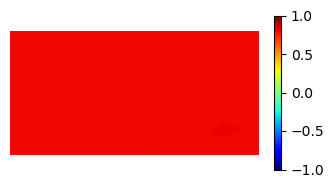

In [27]:
u,v = model.predict(3/5)
plt.figure(dpi=100)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
plt.figure(figsize=(4, 2))
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')

In [29]:
# save_model_param(model, string='star_5')
# save_model_param(model, string='UT_5')
# save_model_param(model, string='rigid_5')

Text(0.5, 1.0, '5')

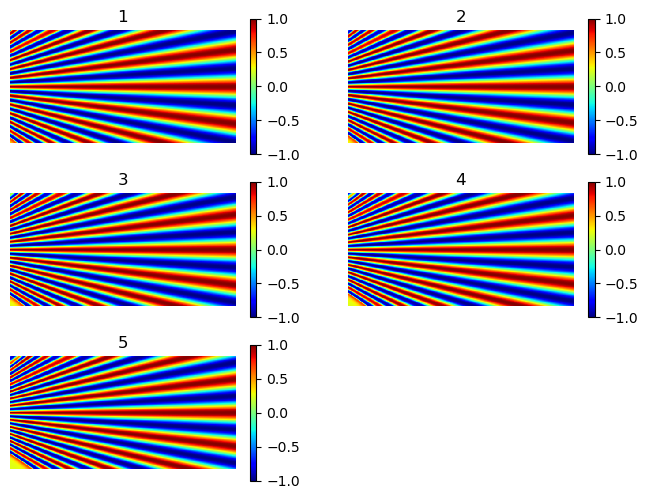

In [36]:
load_model_param(model, string='star_5')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
plt.figure(figsize=(8, 6),dpi=100)
plt.subplot(3, 2, 1)
u,v = model.predict(1/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('1')
plt.subplot(3, 2, 2)
u,v = model.predict(2/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('2')
plt.subplot(3, 2, 3)
u,v = model.predict(3/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('3')
plt.subplot(3, 2, 4)
u,v = model.predict(4/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('4')
plt.subplot(3, 2, 5)
u,v = model.predict(5/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('5')

Text(0.5, 1.0, '5')

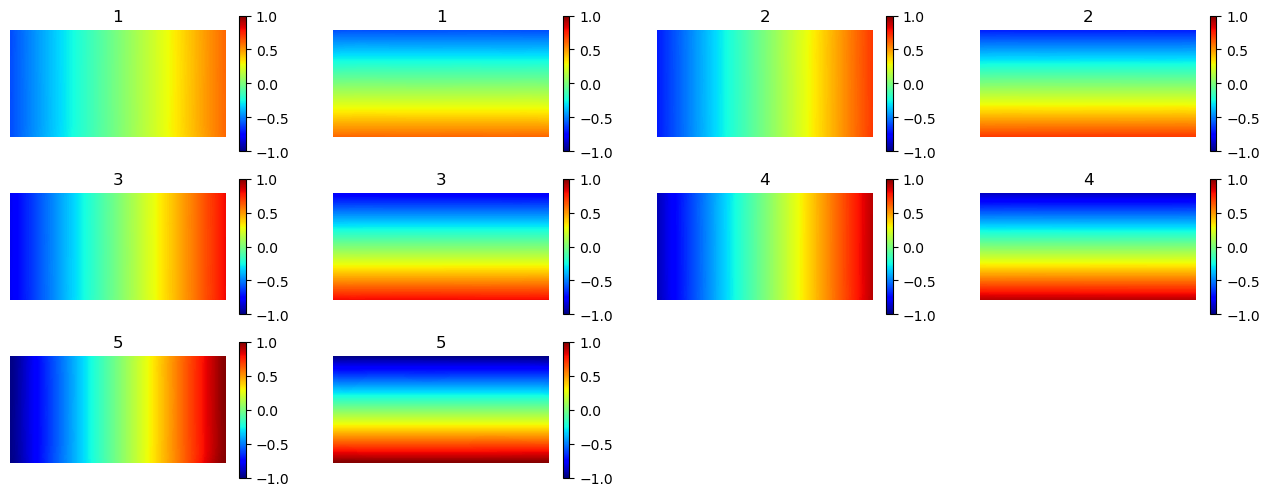

In [40]:
load_model_param(model, string='UT_5')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
plt.figure(figsize=(16, 6),dpi=100)
plt.subplot(3, 4, 1)
u,v = model.predict(1/5)
plt.imshow(u, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('1')
plt.subplot(3, 4, 2)
u,v = model.predict(1/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('1')

plt.subplot(3, 4, 3)
u,v = model.predict(2/5)
plt.imshow(u, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('2')
plt.subplot(3, 4, 4)
u,v = model.predict(2/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('2')

plt.subplot(3, 4, 5)
u,v = model.predict(3/5)
plt.imshow(u, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('3')
plt.subplot(3, 4, 6)
u,v = model.predict(3/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('3')

plt.subplot(3, 4, 7)
u,v = model.predict(4/5)
plt.imshow(u, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('4')
plt.subplot(3, 4, 8)
u,v = model.predict(4/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('4')

plt.subplot(3, 4, 9)
u,v = model.predict(5/5)
plt.imshow(u, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('5')
plt.subplot(3, 4, 10)
u,v = model.predict(5/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('5')

Text(0.5, 1.0, '5')

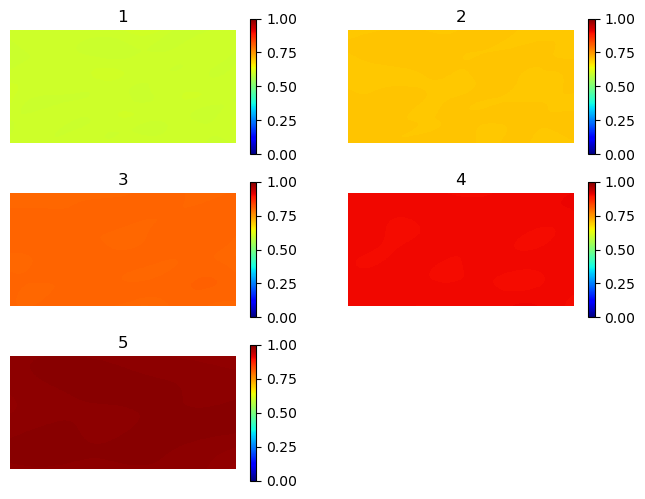

In [37]:
load_model_param(model, string='rigid_5')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
plt.figure(figsize=(8, 6),dpi=100)
plt.subplot(3, 2, 1)
u,v = model.predict(1/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('1')
plt.subplot(3, 2, 2)
u,v = model.predict(2/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('2')
plt.subplot(3, 2, 3)
u,v = model.predict(3/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('3')
plt.subplot(3, 2, 4)
u,v = model.predict(4/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('4')
plt.subplot(3, 2, 5)
u,v = model.predict(5/5)
plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()
plt.axis('off')
plt.title('5')

In [42]:
# load_model_param(model, string='UT_5')
# norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
# plt.figure(figsize=(16, 6), dpi=100)

# # 设置子图的行数和列数
# rows = 3
# cols = 4

# for i in range(1, rows * cols + 1):
#     plt.subplot(rows, cols, i)
#     index = (i - 1) // 2  # 计算模型预测的索引
#     u, v = model.predict(index / 5)
#     if i % 2 != 0:  # 如果是奇数，显示u
#         plt.imshow(u, cmap='jet', interpolation='nearest', norm=norm)
#         plt.title(str(index + 1))
#     else:  # 如果是偶数，显示v
#         plt.imshow(v, cmap='jet', interpolation='nearest', norm=norm)
#         plt.title(str(index + 1))
#     plt.colorbar()
#     plt.axis('off')

# plt.show()
